In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datatools as dtools
from time import time



In [3]:
#
import tensorflow as tf

# tf.enable_eager_execution()

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
import tensorflow_probability
import tensorflow_probability as tfp
tfd = tensorflow_probability.distributions
tfd = tfp.distributions
tfb = tfp.bijectors

import numpy as np
import matplotlib.pyplot as plt
#


In [4]:
# n = 3
# tmpvals = np.random.rand(n,n)
# xx = np.arange(0, 2*n, 2)
# np.meshgrid(xx, xx, xx)
# # indices = []
# # for i in range(2*n):
# #     for j in range(2*n):
# #         for k in range(2*n):
            
# # sp =tf.SparseTensor(indices=[[0, 0, 0], [1, 2, 1]], values=[1, 2], dense_shape=[3, 4, 2])
# # # sp2 = tf.sparse_tensor_to_dense(sp)
# # # with tf.Session() as sess:
# # #     print(sess.run(sp))
# # #     print(sess.run(sp2))


In [5]:
# tf.reset_default_graph()
# def unpool(value, name='unpool'):
#     """N-dimensional version of the unpooling operation from
#     https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf

#     :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
#     :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
#     """
#     with tf.name_scope(name) as scope:
#         sh = value.get_shape().as_list()
#         dim = len(sh[1:-1])
#         out = (tf.reshape(value, [-1] + sh[-dim:]))
#         for i in range(dim, 0, -1):
#             out = tf.concat([out, tf.zeros_like(out)], i)
#         out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
#         out = tf.reshape(out, out_size, name=scope)
#     return out

# a = tf.random_normal([1, 3, 3,  1])
# b = unpool(a)
# with tf.Session() as sess:
#     print(sess.run([a, b]))
# #     print(sess.run(b))


In [138]:

a = tf.random_normal([1, 4, 4,  1])
b = a[:, ::2, ::2, :]
with tf.Session() as sess:
    print(sess.run([ b]))
#     print(sess.run(b))


[array([[[[ 0.01387946],
         [-1.4090097 ]],

        [[ 0.10609611],
         [ 0.2845958 ]]]], dtype=float32)]


In [150]:

a = tf.random_normal([1, 3, 3,  1])
b = unpool(a)
with tf.Session() as sess:
    aa, bb = sess.run([a, b])
#     print(sess.run(b))


In [151]:
print(np.squeeze(aa))
np.squeeze(bb)

[[ 0.98298293 -0.66370183  1.2529548 ]
 [-1.5791045  -1.6466622  -0.36686188]
 [ 1.1114141  -1.8438816   0.7651039 ]]


array([[ 0.98298293,  0.98298293, -0.66370183, -0.66370183,  1.2529548 ,
         1.2529548 ],
       [ 0.98298293,  0.98298293, -0.66370183, -0.66370183,  1.2529548 ,
         1.2529548 ],
       [-1.5791045 , -1.5791045 , -1.6466622 , -1.6466622 , -0.36686188,
        -0.36686188],
       [-1.5791045 , -1.5791045 , -1.6466622 , -1.6466622 , -0.36686188,
        -0.36686188],
       [ 1.1114141 ,  1.1114141 , -1.8438816 , -1.8438816 ,  0.7651039 ,
         0.7651039 ],
       [ 1.1114141 ,  1.1114141 , -1.8438816 , -1.8438816 ,  0.7651039 ,
         0.7651039 ]], dtype=float32)

# Pixel CNN 3D

In [7]:
from pixelcnn3d import *

In [8]:
# import tensorflow as tf
# import numpy as np

# def get_weights3d(shape, name, orientation, mask_mode='noblind', mask=None):
#     weights_initializer = tf.contrib.layers.xavier_initializer()
# #     weights_initializer = tf.ones_initializer()
#     W = tf.get_variable(name, shape, tf.float32, weights_initializer)

#     '''
#         Use of masking to hide subsequent pixel values 
#     '''
#     if mask:
#         filter_mid_x = shape[0]//2
#         filter_mid_y = shape[1]//2
#         filter_mid_z = shape[2]//2
        
#         mask_filter = np.ones(shape, dtype=np.float32)
#         if mask_mode == 'noblind':
                
#             if orientation == 0:
#                 if mask == 'a':
#                     mask_filter[filter_mid_x:, :, :, :, :] = 0.0
#                 else:
#                     mask_filter[filter_mid_x+1:, :, :, :, :] = 0.0

#             elif orientation == 1 :
#                 mask_filter[filter_mid_x+1:, :, :, :, :] = 0.0
#                 if mask == 'a':
#                     mask_filter[filter_mid_x:, filter_mid_y:, :, :, :] = 0.0
#                 else:
#                     mask_filter[filter_mid_x:, filter_mid_y+1:, :, :, :] = 0.0

#             elif orientation == 2:
#                 mask_filter[filter_mid_x+1:, :, :, :, :] = 0.0
#                 mask_filter[filter_mid_x:, filter_mid_y+1:, :, :, :] = 0.0
#                 mask_filter[filter_mid_x:, filter_mid_y:, filter_mid_z+1:, :, :] = 0.0

#             if mask == 'a':
#                 # Center must be zero in first layer
#                 mask_filter[filter_mid_x, filter_mid_y, filter_mid_z, :, :] = 0.0

#         else:
#             mask_filter[filter_mid_x, filter_mid_y:, filter_mid_z+1:, :, :] = 0.
#             mask_filter[filter_mid_x, filter_mid_y+1:, :, :, :] = 0.
#             mask_filter[filter_mid_x+1:, :, :, :, :] = 0.

#             if mask == 'a':
#                 mask_filter[filter_mid_x, filter_mid_y, filter_mid_z, :, :] = 0.
                
#         W = W*mask_filter 
# #         W *= mask_filter
# #         W.assign(W * mask_filter)
#     return W

# def get_bias(shape, name):
#     return tf.get_variable(name, shape, tf.float32, tf.zeros_initializer)

# def conv_op3d(x, W):
#     return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')



# class GatedCNN():
#     def __init__(self, W_shape, fan_in, orientation, gated=True, payload=None, mask=None, 
#                  activation=True, conditional=None, conditional_image=None, cfilter_size=1):
#         self.fan_in = fan_in
#         in_dim = self.fan_in.get_shape()[-1]
#         self.W_shape = [W_shape[0], W_shape[1], W_shape[2], in_dim, W_shape[3]]  
#         self.b_shape = W_shape[3]

#         self.in_dim = in_dim
#         self.payload = payload
#         self.mask = mask
#         self.activation = activation
#         self.conditional = conditional
#         self.conditional_image = conditional_image
#         self.orientation = orientation
#         self.cfilter_size = cfilter_size
        
#         if gated:
#             self.gated_conv()
#         else:
#             self.simple_conv()


#     def gated_conv(self):
#         W_f = get_weights3d(self.W_shape, "v_W", self.orientation, mask=self.mask)
#         W_g = get_weights3d(self.W_shape, "h_W", self.orientation, mask=self.mask)

#         b_f_total = get_bias(self.b_shape, "v_b")
#         b_g_total = get_bias(self.b_shape, "h_b")

#         if self.conditional_image is not None:
#             V_f = tf.layers.conv3d(self.conditional_image, self.in_dim, self.cfilter_size, 
#                                    padding='same', use_bias=False, name="ci_f")
#             V_g = tf.layers.conv3d(self.conditional_image, self.in_dim, self.cfilter_size, 
#                                    padding='same', use_bias=False, name="ci_g")
#             b_f_total = b_f_total + V_f
#             b_g_total = b_g_total + V_g
            
#         conv_f = conv_op3d(self.fan_in, W_f)
#         conv_g = conv_op3d(self.fan_in, W_g)
       
#         if self.payload is not None:
#             conv_f += self.payload
#             conv_g += self.payload

#         self.fan_out = tf.multiply(tf.tanh(conv_f + b_f_total), tf.sigmoid(conv_g + b_g_total))
# #         self.fan_out = conv_f + b_f_total
        
        

#     def simple_conv(self):
#         W = get_weights3d(self.W_shape, "W", self.orientation, mask_mode="standard", mask=self.mask)
#         b = get_bias(self.b_shape, "b")
#         conv = conv_op3d(self.fan_in, W)
#         if self.activation: 
#             self.fan_out = tf.nn.leaky_relu(tf.add(conv, b))
#         else:
#             self.fan_out = tf.add(conv, b)

#     def output(self):
#         return self.fan_out 


# class PixelCNN3D(object):
#     def __init__(self, X, full_horizontal=True, h=None):
#         self.X = X
#         self.X_norm = X
#         v_stack_in, h_stack_in, d_stack_in = self.X_norm, self.X_norm, self.X_norm
#         self.h = None
#         self.im = None #X*0 + 1e-1*np.e
#         nlayers = 5
#         f_map = 8
        
#         for i in range(nlayers):
#             filter_size = 3 if i > 0 else 3
#             mask = 'b' if i > 0 else 'a'
#             residual = True if i > 0 else False
#             i = str(i)
#             with tf.variable_scope("d_stack"+i):
#                 d_stack = GatedCNN([filter_size, filter_size, filter_size, f_map], 
#                                    d_stack_in, 0, mask=mask, 
#                                    conditional=self.h, conditional_image=self.im).output()
#                 d_stack_in = d_stack

#             with tf.variable_scope("d_stack_1"+i):
#                 d_stack_1 = GatedCNN([1, 1, 1, f_map], 
#                                      d_stack_in, 0, gated=False, mask=None).output()

#             with tf.variable_scope("v_stack"+i):
#                 v_stack = GatedCNN([filter_size, filter_size, filter_size, f_map], 
#                                    v_stack_in, 1, payload = d_stack_1, mask=mask, 
#                                    conditional=self.h, conditional_image=self.im).output()
#                 v_stack_in = v_stack

#             with tf.variable_scope("v_stack_1"+i):
#                 v_stack_1 = GatedCNN([1, 1, 1, f_map], 
#                                      v_stack_in, 1, gated=False, mask=None).output()
                
#             with tf.variable_scope("h_stack"+i):
#                 f0size = filter_size if full_horizontal else 1
#                 h_stack = GatedCNN([f0size, filter_size, filter_size, f_map], 
#                                    h_stack_in, 2, payload=v_stack_1, mask=mask, 
#                                    conditional=self.h, conditional_image=self.im).output()

#             with tf.variable_scope("h_stack_1"+i):
#                 h_stack_1 = GatedCNN([1, 1, 1, f_map],
#                                      h_stack, 2, gated=False, mask=None).output()
#                 if residual:
#                     h_stack_1 += h_stack_in # Residual connection
#                 h_stack_in = h_stack_1

        
#         with tf.variable_scope("fc_1"):
#             fc1 = GatedCNN([1, 1, 1, f_map], h_stack_in, orientation=None, gated=False, mask='b').output()

#         with tf.variable_scope("fc_2"):
#             self.fc2 = GatedCNN([1, 1, 1, 1], fc1, orientation=None, gated=False, mask='b', activation=False).output()
#         self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fc2, labels=self.X))
#         self.pred = tf.nn.sigmoid(self.fc2)

        
        
# ### Model                                                                                                                       
# def PixelCNN3Dlayer(i, X, f_map=8, full_horizontal=True, h=None, filter_size=None, 
#                     conditional=None, conditional_im=None, cfilter_size=None):

#     if len(X) == 1:
#         X_norm = X[0]
#         d_stack_in, v_stack_in, h_stack_in = X_norm, X_norm, X_norm
#     else:
#         d_stack_in, v_stack_in, h_stack_in = X

#     if filter_size is None:
#         filter_size = 3 if i > 0 else 5
#     if cfilter_size is None:
#         cfilter_size = filter_size
#     mask = 'b' if i > 0 else 'a'
#     residual = True if i > 0 else False
#     i = str(i)
#     with tf.variable_scope("d_stack"+i):
#         d_stack = GatedCNN([filter_size, filter_size, filter_size, f_map], 
#                            d_stack_in, 0, mask=mask, conditional=conditional, 
#                            conditional_image=conditional_im, cfilter_size=cfilter_size).output()
        
#         d_stack_in = d_stack

#     with tf.variable_scope("d_stack_1"+i):
#         d_stack_1 = GatedCNN([1, 1, 1, f_map], 
#                              d_stack_in, 0, gated=False, mask=None).output()

#     with tf.variable_scope("v_stack"+i):
#         v_stack = GatedCNN([filter_size, filter_size, filter_size, f_map], 
#                            v_stack_in, 1, payload = d_stack_1, mask=mask, conditional=conditional, 
#                            conditional_image=conditional_im, cfilter_size=cfilter_size).output()
#         v_stack_in = v_stack

#     with tf.variable_scope("v_stack_1"+i):
#         v_stack_1 = GatedCNN([1, 1, 1, f_map], 
#                              v_stack_in, 1, gated=False, mask=None).output()

#     with tf.variable_scope("h_stack"+i):
#         f0size = filter_size if full_horizontal else 1
#         h_stack = GatedCNN([f0size, filter_size, filter_size, f_map], 
#                            h_stack_in, 2, payload=v_stack_1, mask=mask, conditional=conditional, 
#                            conditional_image=conditional_im, cfilter_size=cfilter_size).output()

#     with tf.variable_scope("h_stack_1"+i):
#         h_stack_1 = GatedCNN([1, 1, 1, f_map],
#                              h_stack, 2, gated=False, mask=None).output()
#         if residual:
#             h_stack_1 += h_stack_in # Residual connection
#         h_stack_in = h_stack_1


#     return d_stack_in, v_stack_in, h_stack_in

In [9]:
tmp = [1, 3, 44, 21, 4]


In [10]:
tmp.pop()

4

In [13]:
# tf.reset_default_graph()

# W = tf.get_variable('w', (3,3, 1, 1), tf.float32)
# X = tf.get_variable('x', (1, 8, 8, 1), tf.float32)
# Y = tf.nn.conv2d(X, W, [1,1,1,1], 'SAME')
# Z = tf.nn.conv2d(X, W, [1,2,2,1], 'SAME')

# stride = [1, 2, 2, 1]
# filter_size = list(map(int, W.get_shape()))
# num_filters = 1
# xs = list(map(int, Z.get_shape()))
# print(xs)
# target_shape = [xs[0], xs[1]*stride[1], xs[2]*stride[2], 1]
# print(target_shape)
# # target_shape = [xs[0], xs[1]*stride[0] + filter_size[0]-1, xs[2]*stride[1] + filter_size[1]-1, num_filters]
# X2 = tf.nn.conv2d_transpose(Z, W, target_shape, stride, 'SAME')
# # X2 = tf.nn.conv2d_transpose(Z, W, strides= stride, padding='SAME')


# with tf.Session() as sess:
#     sess.run(tf.initializers.global_variables())
#     print(sess.run(X).shape)
#     print(sess.run(Y).shape)
#     print(sess.run(Z).shape)
#     print(sess.run(X2).shape)

In [9]:

# def pixelcnnmodel(X, Y=None, nlayers=2, cfilter_size=None, f_map=1, dnsample=0):
#     """                                                                                                                     
#     Function building the module                                                                                            
#     """

#     conditional_im = Y
#     ul = [[X]]
# #     i=0
# #     ul.append(PixelCNN3Dlayer(0, ul[0], f_map=f_map, full_horizontal=True, h=None, 
# #                             conditional_im=conditional_im, cfilter_size=cfilter_size, debug=True))
# #     ul.append(PixelCNN3Dlayer_dn(1, ul[1], filter_size=1))
# #     ul.append(PixelCNN3Dlayer_up(2, ul[2], filter_size=1))

#     count = len(ul)-1
#     for i in range(count, count+1):
#         ul.append(PixelCNN3Dlayer(i, ul[i], f_map=f_map, full_horizontal=True, h=None, 
#                             conditional_im=conditional_im, cfilter_size=cfilter_size, debug=True))
    
#     print(ul[-1])
# #     ul.append(PixelCNN3Dlayer_dn(i, ul[i+1]))
#     count = len(ul)-1
#     for i in range(count, count+1):
#         ul.append(PixelCNN3Dlayer(i, ul[i], f_map=f_map, full_horizontal=True, h=None, 
#                             conditional_im=conditional_im, cfilter_size=cfilter_size, debug=True))
            
#     print(ul[-1])
# #     ul.append(PixelCNN3Dlayer_up(i, ul[-1]))
#     count = len(ul)-1
#     for i in range(count, count+1):
#         ul.append(PixelCNN3Dlayer(i, ul[i], f_map=f_map, full_horizontal=True, h=None, 
#                            conditional_im=conditional_im, cfilter_size=cfilter_size, debug=True))


#     print(ul[-1])    
#     h_stack_in = ul[-1][-1]
#     with tf.variable_scope("fc_1"):
#         fc1 = GatedCNN([1, 1, 1, f_map], h_stack_in, orientation=None, gated=False, mask='b').output()

#     with tf.variable_scope("fc_2"):
#         fc2 = GatedCNN([1, 1, 1, 1], fc1, orientation=None, gated=False, mask='b', activation=False).output()
#     return fc2
# #     self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fc2, labels=self.X))
# #     self.pred = tf.nn.sigmoid(self.fc2)


In [ ]:
#         cfsize = fsize
#         d1 = wide_resnet(d00, cfsize, activation_fn=tf.nn.leaky_relu)
#         d2 = wide_resnet(d1, cfsize, activation_fn=tf.nn.leaky_relu)
#         dd = [d2]
#         for i in range(nsub):
#             cfsize *= 2
#             print(i, cfsize)
#             dsub = slim.max_pool3d(dd[-1], kernel_size=3, stride=2, padding='SAME')
#             d1 = wide_resnet(dsub, cfsize, activation_fn=tf.nn.leaky_relu)
#             d2 = wide_resnet(d1, cfsize, activation_fn=tf.nn.leaky_relu)
#             dd.append(d2)

#         print(len(dd))
#         #upsample                                                                                         
#         usub =  dd.pop()
#         for i in range(nsub):
#             u0 = dynamic_deconv3d('up%d'%i, usub, shape=[3,3,3,cfsize], activation=tf.identity)
#             cfsize = cfsize // 2
#             print(i, cfsize)
#             u0 = slim.conv3d(u0, cfsize, 1, activation_fn=tf.identity, padding='same')
#             #u0 = slim.conv3d_transpose(usub, fsize, kernel_size=3, stride=2)                             
#             uc = tf.concat([u0, dd.pop()], axis=-1)
#             u1 = wide_resnet(uc, cfsize, activation_fn=tf.nn.leaky_relu)
#             u2 = wide_resnet(u1, cfsize, activation_fn=tf.nn.leaky_relu)
#             usub = u2

#         print(len(dd))
#         net = slim.conv3d(usub, 1, 3, activation_fn=tf.nn.tanh)


In [154]:

def pixelcnnmodel(X, Y=None, nlayers=2, cfilter_size=None, f_map=1, nsub=0):
    """                                                                                                                     
    Function building the module                                                                                            
    """

    conditional_im = Y
    dl = [[X]]
    dres = []
    ilayer = 0
#     count = len(dl)-1
    for i in range(nlayers):
        dl.append(PixelCNN3Dlayer(ilayer, dl[i], f_map=f_map, full_horizontal=True, h=None, 
                            conditional_im=conditional_im, cfilter_size=cfilter_size, debug=True))
        ilayer +=1 
        
    dres.append(dl[-1])
    print(dl[-1])    
    for n in range(nsub):
        dl.append(PixelCNN3Dlayer_dn(i, dl[-1]))
        print(dl[-1])    
        for i in range(nlayers):
            dl.append(PixelCNN3Dlayer(ilayer, dl[-1], f_map=f_map, full_horizontal=True, h=None, 
                            conditional_im=conditional_im, cfilter_size=cfilter_size, debug=True))
            ilayer += 1
        dres.append(dl[-1])
        print(dl[-1])    

    print(len(dl))
    print(dl[-1])    
    ul = [dres.pop()]
    print(ul[-1])

    for n in range(nsub):
        ul.append(PixelCNN3Dlayer_up(i, ul[-1]))
        ul.append(PixelCNN3Dlayer(ilayer, ul[-1], f_map=f_map, full_horizontal=True, h=None, 
                            conditional_im=conditional_im, cfilter_size=cfilter_size, debug=True, 
                                  gated=False, filter_size=1))
        ilayer +=1 
        dcat = dres.pop()
        ul.append([tf.concat([ul[-1][j], dcat[j]], axis=-1) for j in range(3)])
        
        print(ul[-1])
        for i in range(nlayers):
            ul.append(PixelCNN3Dlayer(ilayer, ul[-1], f_map=f_map, full_horizontal=True, h=None, 
                            conditional_im=conditional_im, cfilter_size=cfilter_size, debug=True))
            ilayer +=1
        
            
        print(ul[-1])
    
    print('No of layers : ', ilayer)
    print(ul[-1])    
    h_stack_in = ul[-1][-1]
    print(h_stack_in)
    with tf.variable_scope("fc_1"):
        fc1 = GatedCNN([1, 1, 1, f_map], h_stack_in, orientation=None, gated=False, mask='b').output()

    with tf.variable_scope("fc_2"):
        fc2 = GatedCNN([1, 1, 1, 1], fc1, orientation=None, gated=False, mask='b', activation=False).output()
    return fc2
#     self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fc2, labels=self.X))
#     self.pred = tf.nn.sigmoid(self.fc2)


(<tf.Tensor 'd_stack1/add:0' shape=(1, 16, 16, 16, 1) dtype=float32>, <tf.Tensor 'v_stack1/add_2:0' shape=(1, 16, 16, 16, 1) dtype=float32>, <tf.Tensor 'h_stack_11/add_1:0' shape=(1, 16, 16, 16, 1) dtype=float32>)
(<tf.Tensor 'strided_slice:0' shape=(1, 8, 8, 8, 1) dtype=float32>, <tf.Tensor 'strided_slice_2:0' shape=(1, 8, 8, 8, 1) dtype=float32>, <tf.Tensor 'strided_slice_1:0' shape=(1, 8, 8, 8, 1) dtype=float32>)
(<tf.Tensor 'd_stack3/add:0' shape=(1, 8, 8, 8, 1) dtype=float32>, <tf.Tensor 'v_stack3/add_2:0' shape=(1, 8, 8, 8, 1) dtype=float32>, <tf.Tensor 'h_stack_13/add_1:0' shape=(1, 8, 8, 8, 1) dtype=float32>)
(<tf.Tensor 'strided_slice_3:0' shape=(1, 4, 4, 4, 1) dtype=float32>, <tf.Tensor 'strided_slice_5:0' shape=(1, 4, 4, 4, 1) dtype=float32>, <tf.Tensor 'strided_slice_4:0' shape=(1, 4, 4, 4, 1) dtype=float32>)
(<tf.Tensor 'd_stack5/add:0' shape=(1, 4, 4, 4, 1) dtype=float32>, <tf.Tensor 'v_stack5/add_2:0' shape=(1, 4, 4, 4, 1) dtype=float32>, <tf.Tensor 'h_stack_15/add_1:0' 

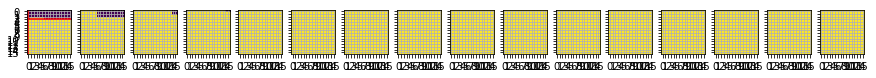

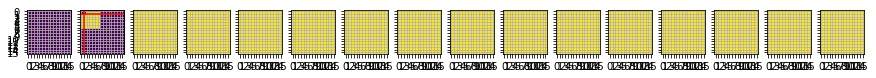

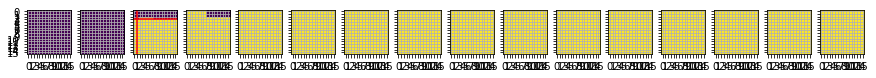

In [166]:
tf.reset_default_graph()
hsize, wsize, dsize = 16, 16, 16
X = tf.placeholder(tf.float32, shape=[1, hsize, wsize, dsize, 1])
pix3d = pixelcnnmodel(X, nlayers=2, nsub=2)
# pix3d = pixelcnnmodel(X, nlayers=5, nsub=0)


preds = []
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    
    index = np.arange(hsize*wsize*dsize).reshape(hsize, wsize, dsize)
    xx = np.ones_like(index)*0.1
#     xx = index.copy()

    xx5 = xx.reshape(1, hsize, wsize, dsize, 1)
    pred0 = sess.run(tf.squeeze(pix3d), {X:xx5})

#     print(pred0)
    for ii, jj, kk in [[0, 3, 0], [1, 1, 1], [2, 3, 1]]:
        xxn = xx5.copy()
        xxn[0, ii, jj, kk, 0] = -np.pi*np.e 
        preds2 = sess.run(tf.squeeze(pix3d), {X:xxn})
        diff = (pred0 - preds2).astype(bool)

        fig, axar = plt.subplots(1, hsize, figsize = (15, 4), sharex=True, sharey=True)
        for i in range(hsize):
#             plt.subplot(1, hsize, i+1)
            
            axar[i].imshow(diff[i], vmin=0, vmax=1)
            for ax in plt.gcf().axes: ax.set_yticks(np.arange(hsize))
            for ax in plt.gcf().axes: ax.set_xticks(np.arange(hsize))
            axar[i].grid()
            if i == ii:
                axar[i].axhline(jj, color='r')
                axar[i].axvline(kk, color='r')    

In [158]:
tf.reset_default_graph()
hsize, wsize, dsize = 8, 8, 8
X = tf.placeholder(tf.float32, shape=[1, hsize, wsize, dsize, 1])
pix3d = pixelcnnmodel(X, nlayers=2, nsub=2)
# pix3d = pixelcnnmodel(X, nlayers=5, nsub=0)


preds = []
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    
    index = np.arange(hsize*wsize*dsize).reshape(hsize, wsize, dsize)
    xx = np.ones_like(index)*0.1
#     xx = index.copy()

    xx5 = xx.reshape(1, hsize, wsize, dsize, 1)
    pred0 = sess.run(tf.squeeze(pix3d), {X:xx5})

#     print(pred0)
    for i in range(hsize):
        tmp = []
        for j in range(wsize):
            tmp2 = []
            for k in range(dsize):
                xxn = xx5.copy()
                xxn[0, i, j, k, 0] = -np.pi*np.e 
                tmp2.append(sess.run(tf.squeeze(pix3d), {X:xxn}))
            tmp.append(tmp2)
        preds.append(tmp)
        
preds = np.array(preds)

(<tf.Tensor 'd_stack1/add:0' shape=(1, 8, 8, 8, 1) dtype=float32>, <tf.Tensor 'v_stack1/add_2:0' shape=(1, 8, 8, 8, 1) dtype=float32>, <tf.Tensor 'h_stack_11/add_1:0' shape=(1, 8, 8, 8, 1) dtype=float32>)
(<tf.Tensor 'strided_slice:0' shape=(1, 4, 4, 4, 1) dtype=float32>, <tf.Tensor 'strided_slice_2:0' shape=(1, 4, 4, 4, 1) dtype=float32>, <tf.Tensor 'strided_slice_1:0' shape=(1, 4, 4, 4, 1) dtype=float32>)
(<tf.Tensor 'd_stack3/add:0' shape=(1, 4, 4, 4, 1) dtype=float32>, <tf.Tensor 'v_stack3/add_2:0' shape=(1, 4, 4, 4, 1) dtype=float32>, <tf.Tensor 'h_stack_13/add_1:0' shape=(1, 4, 4, 4, 1) dtype=float32>)
(<tf.Tensor 'strided_slice_3:0' shape=(1, 2, 2, 2, 1) dtype=float32>, <tf.Tensor 'strided_slice_5:0' shape=(1, 2, 2, 2, 1) dtype=float32>, <tf.Tensor 'strided_slice_4:0' shape=(1, 2, 2, 2, 1) dtype=float32>)
(<tf.Tensor 'd_stack5/add:0' shape=(1, 2, 2, 2, 1) dtype=float32>, <tf.Tensor 'v_stack5/add_2:0' shape=(1, 2, 2, 2, 1) dtype=float32>, <tf.Tensor 'h_stack_15/add_1:0' shape=(1,

0 3 0 24
1 1 1 73
2 3 1 153


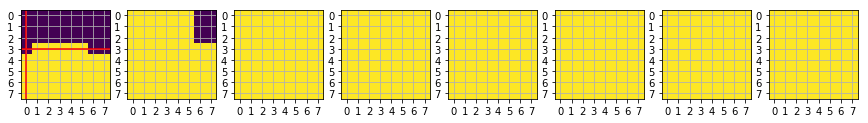

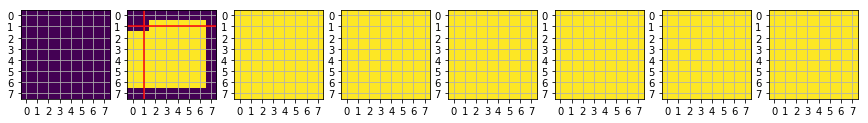

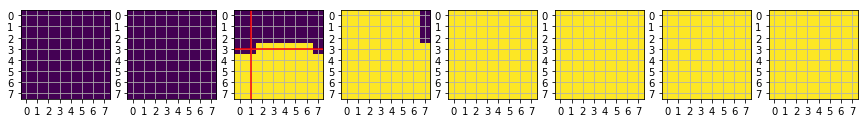

In [159]:
ii, jj, kk = 0, 3, 0
#
# ii, jj, kk = np.random.randint(0, hsize, 3)

for ii, jj, kk in [[0, 3, 0], [1, 1, 1], [2, 3, 1]]:
    print(ii, jj, kk, index[ii, jj, kk])

    diff = (pred0 - preds[ii, jj, kk]).astype(bool)

    plt.figure(figsize = (15, 4))
    for i in range(hsize):
        plt.subplot(1, hsize, i+1)
        plt.imshow(diff[i], vmin=0, vmax=1)
        for ax in plt.gcf().axes: ax.set_yticks(np.arange(hsize))
        for ax in plt.gcf().axes: ax.set_xticks(np.arange(hsize))
        plt.grid()
        if i == ii:
            plt.axhline(jj, color='r')
            plt.axvline(kk, color='r')

0 3 0 24
1 1 1 73
2 3 1 153


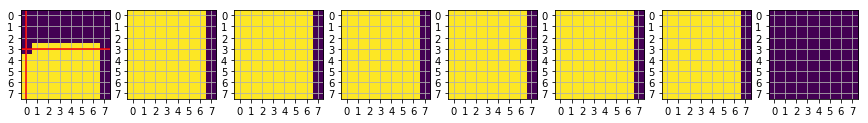

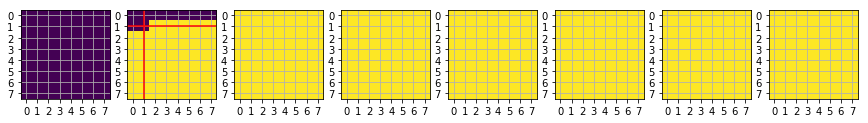

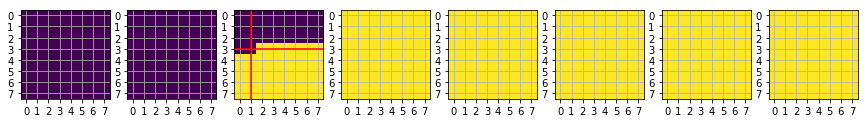

In [117]:
ii, jj, kk = 0, 3, 0
#
# ii, jj, kk = np.random.randint(0, hsize, 3)

for ii, jj, kk in [[0, 3, 0], [1, 1, 1], [2, 3, 1]]:
    print(ii, jj, kk, index[ii, jj, kk])

    diff = (pred0 - preds[ii, jj, kk]).astype(bool)

    plt.figure(figsize = (15, 4))
    for i in range(hsize):
        plt.subplot(1, hsize, i+1)
        plt.imshow(diff[i], vmin=0, vmax=1)
        for ax in plt.gcf().axes: ax.set_yticks(np.arange(hsize))
        for ax in plt.gcf().axes: ax.set_xticks(np.arange(hsize))
        plt.grid()
        if i == ii:
            plt.axhline(jj, color='r')
            plt.axvline(kk, color='r')

0 3 0 24
1 1 1 73
2 3 1 153


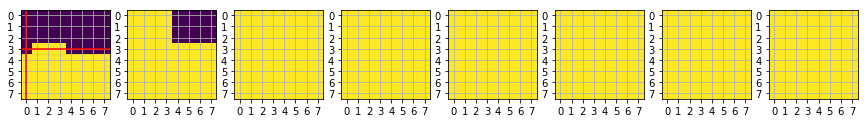

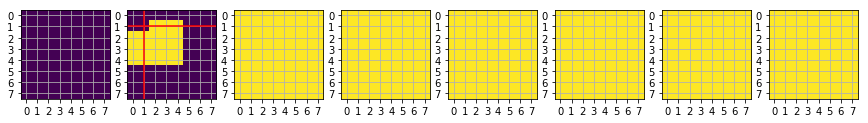

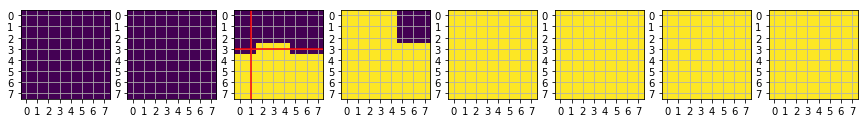

In [113]:
ii, jj, kk = 0, 3, 0
#
# ii, jj, kk = np.random.randint(0, hsize, 3)

for ii, jj, kk in [[0, 3, 0], [1, 1, 1], [2, 3, 1]]:
    print(ii, jj, kk, index[ii, jj, kk])

    diff = (pred0 - preds[ii, jj, kk]).astype(bool)

    plt.figure(figsize = (15, 4))
    for i in range(hsize):
        plt.subplot(1, hsize, i+1)
        plt.imshow(diff[i], vmin=0, vmax=1)
        for ax in plt.gcf().axes: ax.set_yticks(np.arange(hsize))
        for ax in plt.gcf().axes: ax.set_xticks(np.arange(hsize))
        plt.grid()
        if i == ii:
            plt.axhline(jj, color='r')
            plt.axvline(kk, color='r')

2 3 1 153


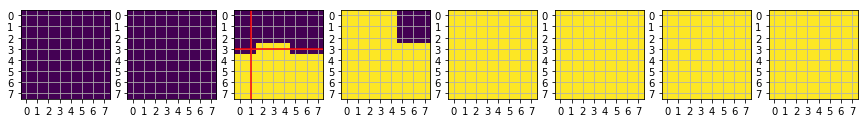

In [111]:
ii, jj, kk = 2, 3, 1
#
# ii, jj, kk = np.random.randint(0, hsize, 3)
print(ii, jj, kk, index[ii, jj, kk])

diff = (pred0 - preds[ii, jj, kk]).astype(bool)
# expect = np.arange(index[ii, jj, kk]+1, index.size, 1)
# changed = index[diff]
# print(expect.size, changed.size)
# print(expect.min(), changed.min())

plt.figure(figsize = (15, 4))
for i in range(hsize):
    plt.subplot(1, hsize, i+1)
    plt.imshow(diff[i], vmin=0, vmax=1)
    for ax in plt.gcf().axes: ax.set_yticks(np.arange(hsize))
    for ax in plt.gcf().axes: ax.set_xticks(np.arange(hsize))
    plt.grid()
    if i == ii:
        plt.axhline(jj, color='r')
        plt.axvline(kk, color='r')

In [46]:

for ii in range(hsize):
    for jj in range(hsize):
        for kk in range(hsize):    
            diff = (pred0 - preds[ii, jj, kk]).astype(bool)
            expect = np.arange(index[ii, jj, kk]+1, index.size, 1)
            changed = index[diff]
            if len(set(expect) - set(changed)) > 0: print(ii, jj, kk)
            if len(set(changed) - set(expect)) > 0: print(ii, jj, kk)
    

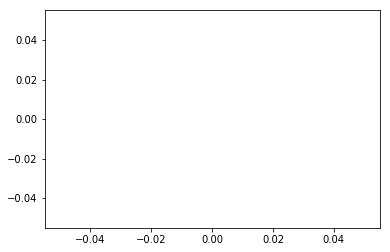

In [47]:
plt.plot(expect, expect, 'o')
plt.plot(changed, changed, 'x')

# Data

In [13]:
#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
# path = '/data2/cosmo4d/'
path = '../data/z00/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200, 300, 400]

cube_sizes = np.array([8, 16, 32, 64, 128])
# cube_sizes = np.array([32])
num_cubes= 500#(500*8/cube_sizes).astype('int')
pad = 0
cube_sizesft = cube_sizes + 2*pad
max_offset = ncp - cube_sizes
ftname = ['cic']
nchannels = len(ftname)
rprob = 0.5

    
    
#############################
##Read data and generate meshes
meshes = {}
cube_features, cube_target = [[] for i in range(len(cube_sizes))], [[] for i in range(len(cube_sizes))]

for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)

    hmesh = {}
    ##Uncomment for galaxies
#     hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
#     hposd = tools.readbigfile(hpath + 'Position/')
#     massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)*1e10
#     galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
#     hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
#     hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)
#     hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
#     targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]    
    hposd = hposall[:num].copy()
#     massd = massall[:num].copy()
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    targetmesh = [hmesh['pnn']]
#     #hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
#     #hmesh['mnn'] = tools.paintnn(hposd, bs, ncp, massd)

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    ntarget = len(targetmesh)

    for i, size in enumerate(cube_sizes):
        print('For size = ', size)
        if size==nc:
            features = [np.stack(ftlistpad, axis=-1)]
            target = [np.stack(targetmesh, axis=-1)]
        else:
            numcubes = int(num_cubes/size*4)
            features, target = dtools.randomvoxels(ftlistpad, targetmesh, numcubes, max_offset[i],
                                            size, cube_sizesft[i], seed=seed, rprob=0)
        cube_features[i] = cube_features[i] + features
        cube_target[i] = cube_target[i] + target

# #
for i in range(cube_sizes.size):
    cube_target[i] = np.stack(cube_target[i],axis=0)
    cube_features[i] = np.stack(cube_features[i],axis=0)
    print(cube_features[i].shape, cube_target[i].shape)

    


All the mesh have been generated for seed = 100
For size =  8
Length of targets =  1
Supplemented by rotation :  0
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
For size =  128
All the mesh have been generated for seed = 200
For size =  8
Length of targets =  1
Supplemented by rotation :  0
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
For size =  128
All the mesh have been generated for seed = 300
For size =  8
Length of targets =  1
Supplemented by rotation :  0
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
For size = 

In [14]:
np.random.choice(len(cube_sizes), 1, replace=True)[0]

3

In [15]:
batch_size=64
rprob = 0.5

def mapping_function(inds):
    def extract_batch(inds):
        #isize = np.random.choice(len(cube_sizes), 1, replace=True)[0]
        isize = 2
        batch = int(batch_size*8/cube_sizes[isize])
        if cube_sizes[isize]==nc : batch = 1
        inds = inds[:batch]
        trainingsize = cube_features[isize].shape[0]
        inds[inds >= trainingsize] =  (inds[inds >= trainingsize])%trainingsize

        features = cube_features[isize][inds].astype('float32')
        targets = cube_target[isize][inds].astype('float32')

        for i in range(batch):
            nrotations=0
            while (np.random.random() < rprob) & (nrotations < 3):
                nrot, ax0, ax1 = np.random.randint(0, 3), *np.random.permutation((0, 1, 2))[:2]
                features[i] = np.rot90(features[i], nrot, (ax0, ax1))
                targets[i] = np.rot90(targets[i], nrot, (ax0, ax1))
                nrotations +=1
    #         masks = np.clip(targets, 0, 1)
    #         targets = np.concatenate((targets, masks), axis=-1)
    #         print(targets.shape)
#         return features, targets
        return targets, features

    ft, tg = tf.py_func(extract_batch, [inds],
                        [tf.float32, tf.float32])
    return ft, tg


def training_input_fn():
    """Serving input fn for training data"""

    dataset = tf.data.Dataset.range(len(np.array(cube_features)[0]))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    dataset = dataset.map(mapping_function)
    dataset = dataset.prefetch(16)
    return dataset


def testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.range(len(cube_features))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_function)
    return dataset

In [16]:



def _mdn_pixmodel_fn(features, labels, nchannels, n_y, n_mixture, dropout, optimizer, mode, pad, 
                    cfilter_size=None):

    # Check for training mode                                                                                                   
    is_training = mode == tf.estimator.ModeKeys.TRAIN

    def _module_fn():
        """                                                                                                                     
        Function building the module                                                                                            
        """

        feature_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
        obs_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, n_y], name='observations')

        conditional_im = wide_resnet(feature_layer, 16, activation_fn=tf.nn.leaky_relu, 
                                     keep_prob=dropout, is_training=is_training)
#         conditional_im = wide_resnet(conditional_im, 1, activation_fn=tf.nn.leaky_relu, 
#                                      keep_prob=dropout, is_training=is_training)
        inputnet = obs_layer
        
#         fnet = wide_resnet(feature_layer, 16, activation_fn=tf.nn.leaky_relu, 
#                                      keep_prob=dropout, is_training=is_training)
#         fnet = wide_resnet(fnet, 1, activation_fn=tf.nn.leaky_relu, 
#                                      keep_prob=dropout, is_training=is_training)
        
#         inputnet = tf.concat((obs_layer, fnet), axis=-1)
#         conditional_im = None
        # Builds the neural network                                                                                             
        stacks0 = PixelCNN3Dlayer(0, [inputnet], f_map=8, full_horizontal=True, h=None, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        stacks1 = PixelCNN3Dlayer(1, stacks0, f_map=8, full_horizontal=True, h=None, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        stacks2 = PixelCNN3Dlayer(2, stacks1, f_map=8, full_horizontal=True, h=None, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        stacks3 = PixelCNN3Dlayer(3, stacks2, f_map=8, full_horizontal=True, h=cfilter_size, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        stacks4 = PixelCNN3Dlayer(4, stacks3, f_map=8, full_horizontal=True, h=None, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        
        h_stack_in = stacks4[-1]
#         print(h_stack_in)
        
        with tf.variable_scope("fc_1"):
            fc1 = GatedCNN([1, 1, 1, 1], h_stack_in, orientation=None, gated=False, mask='b').output()

        with tf.variable_scope("fc_2"):
            fc2 = GatedCNN([1, 1, 1, n_mixture*3*n_y], fc1, orientation=None, 
                                gated=False, mask='b', activation=False).output()

        
        cube_size = tf.shape(obs_layer)[1]
        net = tf.reshape(fc2, [-1, cube_size, cube_size, cube_size, n_y, n_mixture*3])

        loc, unconstrained_scale, logits = tf.split(net,
                                                    num_or_size_splits=3,
                                                    axis=-1)
        scale = tf.nn.softplus(unconstrained_scale)

        # Form mixture of discretized logistic distributions. Note we shift the                                                 
        # logistic distribution by -0.5. This lets the quantization capture "rounding"                                          
        # intervals, `(x-0.5, x+0.5]`, and not "ceiling" intervals, `(x-1, x]`.                                                 
#         discretized_logistic_dist = tfd.QuantizedDistribution(
#             distribution=tfd.TransformedDistribution(
#                 distribution=tfd.Logistic(loc=loc, scale=scale),
#                 bijector=tfb.AffineScalar(shift=-0.5)),
#             low=0.,
#             high=2.**3-1)

        mixture_dist = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(logits=logits),
            components_distribution=tfd.Normal(loc, scale))

        # Define a function for sampling, and a function for estimating the log likelihood                                      
        #sample = tf.squeeze(mixture_dist.sample())                                                                             
        sample = mixture_dist.sample()
        loglik = mixture_dist.log_prob(obs_layer)
        hub.add_signature(inputs={'features':feature_layer, 'labels':obs_layer},
                          outputs={'sample':sample, 'loglikelihood':loglik,
                                   'loc':loc, 'scale':scale, 'logits':logits})

    # Create model and register module if necessary                                                                     
    spec = hub.create_module_spec(_module_fn)
    module = hub.Module(spec, trainable=True)
    if isinstance(features,dict):
        predictions = module(features, as_dict=True)
    else:
        predictions = module({'features':features, 'labels':labels}, as_dict=True)

    if mode == tf.estimator.ModeKeys.PREDICT:
        hub.register_module_for_export(module, "likelihood")
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loglik = predictions['loglikelihood']
    # Compute and register loss function                                                                                
    neg_log_likelihood = -tf.reduce_sum(loglik, axis=-1)
    neg_log_likelihood = tf.reduce_mean(neg_log_likelihood)

    tf.losses.add_loss(neg_log_likelihood)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

    train_op = None
    eval_metric_ops = None

    # Define optimizer                                                                                                  
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            global_step=tf.train.get_global_step()
            boundaries = list(np.array([2e3, 5e3, 1e4, 2e4, 3e4]).astype(int))
            values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6]
            learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
            train_op = optimizer(learning_rate=learning_rate).minimize(loss=total_loss, global_step=global_step)
            tf.summary.scalar('rate', learning_rate)
        tf.summary.scalar('loss', neg_log_likelihood)
    elif mode == tf.estimator.ModeKeys.EVAL:

        eval_metric_ops = { "log_p": neg_log_likelihood}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)



In [ ]:

def _mdn_pixmodel_unet_fn(features, labels, nchannels, n_y, n_mixture, dropout, optimizer, mode, pad, 
                    cfilter_size=None):

    # Check for training mode                                                                                                   
    is_training = mode == tf.estimator.ModeKeys.TRAIN

    def _module_fn():
        """                                                                                                                     
        Function building the module                                                                                            
        """

        feature_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
        obs_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, n_y], name='observations')

        conditional_im = wide_resnet(feature_layer, 16, activation_fn=tf.nn.leaky_relu, 
                                     keep_prob=dropout, is_training=is_training)
#         conditional_im = wide_resnet(conditional_im, 1, activation_fn=tf.nn.leaky_relu, 
#                                      keep_prob=dropout, is_training=is_training)
        inputnet = obs_layer
        
#         fnet = wide_resnet(feature_layer, 16, activation_fn=tf.nn.leaky_relu, 
#                                      keep_prob=dropout, is_training=is_training)
#         fnet = wide_resnet(fnet, 1, activation_fn=tf.nn.leaky_relu, 
#                                      keep_prob=dropout, is_training=is_training)
        
#         inputnet = tf.concat((obs_layer, fnet), axis=-1)
#         conditional_im = None
        # Builds the neural network                                                                                             
        stacks0 = PixelCNN3Dlayer(0, [inputnet], f_map=8, full_horizontal=True, h=None, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        stacks1 = PixelCNN3Dlayer(1, stacks0, f_map=8, full_horizontal=True, h=None, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        stacks2 = PixelCNN3Dlayer(2, stacks1, f_map=8, full_horizontal=True, h=None, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        stacks3 = PixelCNN3Dlayer(3, stacks2, f_map=8, full_horizontal=True, h=cfilter_size, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        stacks4 = PixelCNN3Dlayer(4, stacks3, f_map=8, full_horizontal=True, h=None, 
                                 conditional_im=conditional_im, cfilter_size=cfilter_size)
        
        h_stack_in = stacks4[-1]
#         print(h_stack_in)
        
        with tf.variable_scope("fc_1"):
            fc1 = GatedCNN([1, 1, 1, 1], h_stack_in, orientation=None, gated=False, mask='b').output()

        with tf.variable_scope("fc_2"):
            fc2 = GatedCNN([1, 1, 1, n_mixture*3*n_y], fc1, orientation=None, 
                                gated=False, mask='b', activation=False).output()

        
        cube_size = tf.shape(obs_layer)[1]
        net = tf.reshape(fc2, [-1, cube_size, cube_size, cube_size, n_y, n_mixture*3])

        loc, unconstrained_scale, logits = tf.split(net,
                                                    num_or_size_splits=3,
                                                    axis=-1)
        scale = tf.nn.softplus(unconstrained_scale)

        # Form mixture of discretized logistic distributions. Note we shift the                                                 
        # logistic distribution by -0.5. This lets the quantization capture "rounding"                                          
        # intervals, `(x-0.5, x+0.5]`, and not "ceiling" intervals, `(x-1, x]`.                                                 
#         discretized_logistic_dist = tfd.QuantizedDistribution(
#             distribution=tfd.TransformedDistribution(
#                 distribution=tfd.Logistic(loc=loc, scale=scale),
#                 bijector=tfb.AffineScalar(shift=-0.5)),
#             low=0.,
#             high=2.**3-1)

        mixture_dist = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(logits=logits),
            components_distribution=tfd.Normal(loc, scale))

        # Define a function for sampling, and a function for estimating the log likelihood                                      
        #sample = tf.squeeze(mixture_dist.sample())                                                                             
        sample = mixture_dist.sample()
        loglik = mixture_dist.log_prob(obs_layer)
        hub.add_signature(inputs={'features':feature_layer, 'labels':obs_layer},
                          outputs={'sample':sample, 'loglikelihood':loglik,
                                   'loc':loc, 'scale':scale, 'logits':logits})

    # Create model and register module if necessary                                                                     
    spec = hub.create_module_spec(_module_fn)
    module = hub.Module(spec, trainable=True)
    if isinstance(features,dict):
        predictions = module(features, as_dict=True)
    else:
        predictions = module({'features':features, 'labels':labels}, as_dict=True)

    if mode == tf.estimator.ModeKeys.PREDICT:
        hub.register_module_for_export(module, "likelihood")
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loglik = predictions['loglikelihood']
    # Compute and register loss function                                                                                
    neg_log_likelihood = -tf.reduce_sum(loglik, axis=-1)
    neg_log_likelihood = tf.reduce_mean(neg_log_likelihood)

    tf.losses.add_loss(neg_log_likelihood)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

    train_op = None
    eval_metric_ops = None

    # Define optimizer                                                                                                  
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            global_step=tf.train.get_global_step()
            boundaries = list(np.array([2e3, 5e3, 1e4, 2e4, 3e4]).astype(int))
            values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6]
            learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
            train_op = optimizer(learning_rate=learning_rate).minimize(loss=total_loss, global_step=global_step)
            tf.summary.scalar('rate', learning_rate)
        tf.summary.scalar('loss', neg_log_likelihood)
    elif mode == tf.estimator.ModeKeys.EVAL:

        eval_metric_ops = { "log_p": neg_log_likelihood}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)



In [17]:

class MDNEstimator(tf.estimator.Estimator):
    """An estimator for distribution estimation using Mixture Density Networks.
    """

    def __init__(self,
                 n_y,
                 n_mixture,
                 optimizer=tf.train.AdamOptimizer,
                 dropout=None,
                 model_dir=None,
                 config=None):
        """Initializes a `MDNEstimator` instance.
        """


        def _model_fn(features, labels, mode):
            return _mdn_pixmodel_fn(features, labels,
                                 nchannels, n_y, n_mixture, dropout,
                                               optimizer, mode, pad)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
        


# Train

In [529]:
%%bash 
ls ./models/galmodel
# rm -r ./models/galmodel/pix3dcond

maskpos
maskpostest
mass
model0
model1
model2
module0
module02
module1
module2
nozero
pix3d
pix3dcond
pix3dcondv2
README
tmp


In [18]:
savepath = './models/galmodel/pix3dinv'

run_config = tf.estimator.RunConfig(save_checkpoints_steps = 1000)

model =  MDNEstimator(n_y=ntarget, n_mixture=8, dropout=0.95,
                      model_dir=savepath + '/model/', config = run_config)
#                       model_dir='./tmp/galmodel/model0', config = run_config)

INFO:tensorflow:Using config: {'_model_dir': './models/galmodel/pix3dinv/model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f63f8628390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [38]:
model.train(training_input_fn, max_steps=1000)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/galmodel/pix3dinv/model/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 500 into ./models/galmodel/pix3dinv/model/model.ckpt.
INFO:tensorflow:loss = 0.6908262, step = 500
INFO:tensorflow:global_step/sec: 1.39836
INFO:tensorflow:loss = 0.644362, step = 600 (71.514 sec)
INFO:tensorflow:global_step/sec: 1.42557
INFO:tensorflow:loss = 0.5121794, step = 700 (70.147 sec)
INFO:tensorflow:global_step/sec: 1.4259
INFO:tensorflow:loss = 0.4767241, step = 800 (70.131 sec)
INFO:tensorflow:global_step/sec: 1.42595
INFO:tensorflow:loss = 0.4626755, step = 900 (70.129 sec)
INFO:tensorflow:Saving checkpoints for 1000 into ./models/galmodel/pix3dinv/model/mode

In [39]:
# Trying to export
features = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
labels = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='observations')
    
exporter = hub.LatestModuleExporter("tf_hub", tf.estimator.export.build_raw_serving_input_receiver_fn({'features':features, 'labels':labels},
                                                                   default_batch_size=None))

modulepath = exporter.export(model, savepath + '/module/', model.latest_checkpoint())
modulepath = modulepath.decode("utf-8")


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Restoring parameters from ./models/galmodel/pix3dinv/model/model.ckpt-1000
INFO:tensorflow:Exported TF-Hub module to: b"./models/galmodel/pix3dinv/module/temp-b'1561694611'/likelihood"


# Check

In [40]:
cube_features[0].shape

(1000, 8, 8, 8, 1)

In [41]:
tf.reset_default_graph()
module = hub.Module(modulepath + '/likelihood/')
# module = pad4-nozero_maskpos_rewt/module/1554184418
# module = hub.Module('../code/models/n10/pad4-nozero_maskpos_rewt/module/1554184418/likelihood/')
xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']
# loss = module(dict(features=xx, labels=yy), as_dict=True)['loss']
# loss1 = module(dict(features=xx, labels=yy), as_dict=True)['loss1']
# loss2 = module(dict(features=xx, labels=yy), as_dict=True)['loss2']
# out_masks =  module(dict(features=xx, labels=yy), as_dict=True)['out_mask']
# pred_masks =  module(dict(features=xx, labels=yy), as_dict=True)['pred_mask']

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
#     features = cube_features[2][0:8].astype('float32')
#     targets = cube_target[2][0:8].astype('float32')
    features = cube_target[2][0:8].astype('float32')
    targets = cube_features[2][0:8].astype('float32')
    xxm = features
    yym = targets
    
    print(xxm.shape, yym.shape)
    loss = sess.run(tf.squeeze(loglik), feed_dict={xx:xxm, yy:yym})

#     xxn = np.fft.irfftn(np.fft.rfftn(xxm, axes=(1, 2, 3), norm='ortho')/2., axes=(1, 2, 3), norm='ortho')
    xxn = np.roll(xxm, 16, 1)
    xxn = xxm
    yyn = yym
    yyn = np.roll(yym, 7, 1)
    loss2 = sess.run(tf.squeeze(loglik), feed_dict={xx:xxn, yy:yyn})
    



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(8, 32, 32, 32, 1) (8, 32, 32, 32, 1)


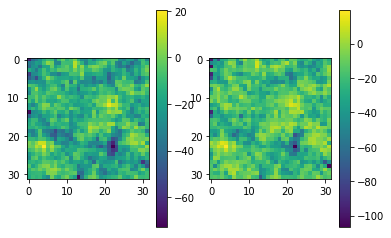

In [42]:
plt.subplot(121)
plt.imshow(loss[1].sum(axis=0))
plt.colorbar()
plt.subplot(122)
plt.imshow(loss2[1].sum(axis=0))
plt.colorbar()


In [51]:
start = time()
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
#     features = cube_features[1][0:1].astype('float32')
#     targets = cube_target[1][0:1].astype('float32')
    features = cube_target[2][0:1].astype('float32')
    targets = cube_features[2][0:1].astype('float32')
    xxm = features
    yym = targets

    sample = np.zeros_like(yym)
    sample2 = sess.run(samples, feed_dict={xx:xxm, yy:yym*0})
    for i in range(yym.shape[1]):
        for j in range(yym.shape[2]):
            for k in range(yym.shape[3]):
                data_dict = {xx:xxm, yy:sample}
                next_sample = sess.run(samples, feed_dict=data_dict)
                sample[:, i, j, k, :] = next_sample[:, i, j, k, :]
    
#     print(sess.run(tf.squeeze(loglik), feed_dict={xx:xxm, yy:np.expand_dims(sample, axis=-1)}))
    loss = sess.run(tf.squeeze(loglik), feed_dict={xx:xxm, yy:sample})
    loss2 = sess.run(tf.squeeze(loglik), feed_dict={xx:xxm, yy:sample2})

end = time()
print('Taken : ', end-start)

Taken :  654.4292306900024


In [44]:
# yym = np.squeeze(yym)
# sample  = np.squeeze(sample) 
# sample2 = np.squeeze(sample2) 

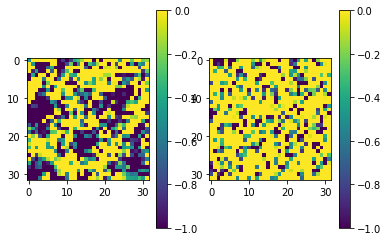

In [52]:
plt.subplot(121)
plt.imshow(loss[0,...], vmin=0, vmax=-1)
plt.colorbar()
plt.subplot(122)
plt.imshow(loss2[0,...], vmin=0, vmax=-1)
plt.colorbar()


In [53]:
loss.sum(), loss2.sum()

(-12012.756, 5326.3843)

In [54]:
sample[0].sum(), sample2[0].sum(), yym[0].sum()

(22396.977, 5847.6606, 28290.008)

In [55]:
cube_features[2].max()

188.83639405122932

In [60]:
yym.std(), sample.std(), sample2.std()

(1.6938311, 1.247058, 0.25131953)

In [1]:
plt.hist(np.log(1+yym.flatten()), range=(-2, 2))
plt.hist(np.log(1+sample.flatten()), alpha=0.5, range=(-2, 2))
plt.hist(np.log(1+sample2.flatten()), alpha=0.5, range=(-2, 2))

NameError: name 'plt' is not defined

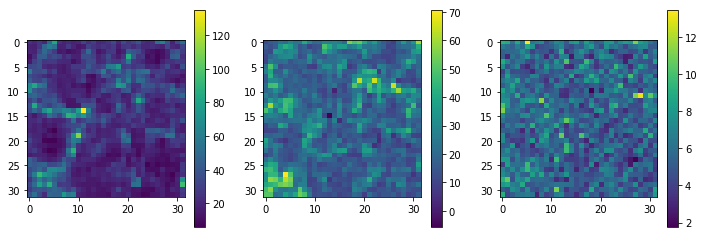

In [72]:
vmin, vmax = None, None

plt.figure(figsize = (12, 4))
plt.subplot(131)
plt.imshow(yym[0,...,0].sum(axis=0), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(132)
plt.imshow(sample[0,...,0].sum(axis=0), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(133)
plt.imshow(sample2[0,...,0].sum(axis=0), vmin=vmin, vmax=vmax)
plt.colorbar()


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


[]

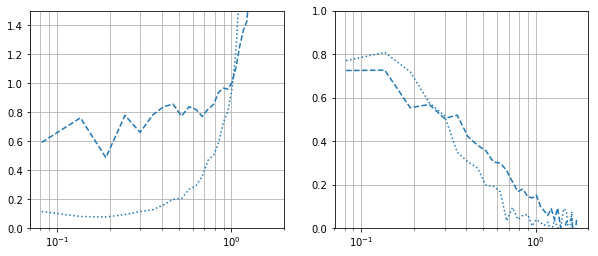

In [62]:
ii = 0
k, ph = tools.power(yym[ii,...,], boxsize=bs/4)
k, pp1 = tools.power(sample[ii,...,], boxsize=bs/4)
k, pp1x = tools.power(sample[ii,...,], yym[ii,...,], boxsize=bs/4)
k, pp2 = tools.power(sample2[ii,...,], boxsize=bs/4)
k, pp2x = tools.power(sample2[ii,...,], yym[ii,...,], boxsize=bs/4)


plt.figure(figsize = (10, 4))
plt.subplot(121)
# plt.plot(k, ph, 'C%d-'%ii)
plt.plot(k, pp1/ph, 'C%d--'%ii)
plt.plot(k, pp2/ph, 'C%d:'%ii)
plt.ylim(0, 1.5)
plt.grid(which='both')
plt.semilogx()
# plt.loglog()

plt.subplot(122)
plt.plot(k, pp1x/(pp1*ph)**0.5, 'C%d--'%ii)
plt.plot(k, pp2x/(pp2*ph)**0.5, 'C%d:'%ii)
plt.ylim(0, 1)
plt.grid(which='both')
plt.semilogx()

In [ ]:
plt.plot(*tools.power(yym[0,...,], boxsize=bs), 'C0--')
plt.plot(*tools.power(yym[1,...,], boxsize=bs), 'C1--')
plt.plot(*tools.power(sample[0,...], boxsize=bs), 'C0-')
plt.plot(*tools.power(sample[1,...], boxsize=bs), 'C1-')
plt.plot(*tools.power(sample2[0,...], boxsize=bs), 'C0:')
plt.plot(*tools.power(sample2[1,...], boxsize=bs), 'C1:')
plt.loglog()